In [1]:
!nvidia-smi

Sun Jan 24 01:33:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Build data

In [3]:
import sys
import os
import time
from shutil import copyfile
import numpy as np
import json
import cv2
from pprint import pprint
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image

### Prepare line images and annotations

In [ ]:
# !rm -r dense_rename
# !rm -r labeled_rename/
# !rm -r line_images
# !rm -r line_texts
# !rm -r ocr_training
# !rm -r page_images

In [ ]:
# !cp /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/dense_renamed.zip /content/dense_renamed.zip
# !cp /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/labeled_renamed.zip /content/labeled_renamed.zip

# !mkdir ocr_training/
# !mkdir ocr_training/page_images

# !unzip -qq /content/dense_renamed.zip
# !mv /content/rename/* /content/ocr_training/page_images/

# !unzip -qq /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/labeled_renamed.zip
# !mv /content/rename/* /content/ocr_training/page_images
len(os.listdir('ocr_training/page_images')), len(os.listdir('rename'))

mkdir: cannot create directory ‘ocr_training/’: File exists
mkdir: cannot create directory ‘ocr_training/page_images’: File exists


In [ ]:
def get_file_path_by_type(path, extensions=('.jpg', '.png')):
    img_paths = []
    for x in os.listdir(path):
        for ext in extensions:
            if x.endswith(ext):
                img_paths.append(path + '/' + x)

    return img_paths

def get_file_name_by_type(path, extensions=('.jpg', '.png')):
    img_paths = []
    for x in os.listdir(path):
        for ext in extensions:
            if x.endswith(ext):
                img_paths.append(x)

    return img_paths


def drop_extension(file_path):
    """
    Drop file extension of a file path.
    """
    return os.path.splitext(file_path)[0]

        
def get_all_text(path_list):
    """
    Combine text files into one .txt file.
    """
    all_texts = ""
    for file in path_list:
        all_texts += '\n' + open(file, 'r', encoding='utf8').read().strip()
    
    return all_texts.strip()


def combine_texts(path_list, out_file_path='all_text.txt'):
    all_texts = get_all_text(path_list)
    #save to out_file
    with open(out_file_path, 'w+', encoding='utf8') as f:
        f.write(all_texts)

In [ ]:
# path_list = get_file_path_by_type("line_annotations/", extensions=('.txt'))
# combine_texts(path_list)

In [ ]:
def bb_converter(coords: list):
    """
    Convert 8-coord bounding box to 4-coord bounding box.
    """
    return coords[0], coords[1], coords[4], coords[5]


def crop_rectangle(img, box=(None, None, None, None)):
    x1, y1, x2, y2 = box  # top_left_x, top_left_y, bot_right_x, bot_right_y
    return img[y1:y2, x1:x2, :]


def extract_element_from_page(img, json_annotations_object, extend_up_y=0.0, extend_down_y=0.0):
    cropped_imgs = []
    texts = []
    for idx, component in enumerate(json_annotations_object):
        x1, y1, x2, y2 = bb_converter(component["boundingBox"])

        y1 -= int(extend_up_y*(y2-y1))
        y2 += int(extend_down_y*(y2-y1))
        if x2-x1 < 32:
            x2 = x1 + y2-y1 + 3

        cropped_imgs.append(crop_rectangle(img, box=(x1, y1, x2, y2)))
        texts.append(component['text'])
        
    return cropped_imgs, texts
        

def save_elements(img_list, text_list, prefix, dst_img='line_images', dst_text='line_texts'):
    for idx, (img, s) in enumerate(zip(img_list, text_list)):
        img_path = dst_img + "/" + prefix + "_" + '{:0>3}'.format(str(idx)) + ".jpg"
        text_path = dst_text + "/" + prefix + ".txt"

        text_line = img_path + '\t' + s

        # write
        try:
            cv2.imwrite(img_path, img)
            with open(text_path, 'a', encoding='utf8') as f:
                f.write('\n'+text_line)
        except:
            pass

In [ ]:
from tqdm import tqdm

def extract_elements(src_folder, dst_img='line_images', dst_text='line_texts'):
    # make dst if not exist
    if not os.path.exists(dst_img):
        os.mkdir(dst_img)
    if not os.path.exists(dst_text):
        os.mkdir(dst_text)
    
    # get all img path in src_folder
    img_name_list = get_file_name_by_type(src_folder, extensions=('.jpg', '.png'))
    
    for idx, img_name in enumerate(img_name_list):
        if idx % 100 == 0:
            print(idx)
            
        page_name = drop_extension(img_name)
        json_path = src_folder + "/" + page_name + '_lines.json'
        img_path = src_folder + "/" + img_name
        
        page_layout = json.load(open(json_path, 'r', encoding='utf8'))
        page_img = cv2.imread(img_path)
        
        cur_page_line_imgs, cur_page_line_texts = extract_element_from_page(page_img, page_layout)  # list of line imgs

        save_elements(img_list=cur_page_line_imgs, 
                      text_list=cur_page_line_texts, 
                      prefix=page_name, 
                      dst_img=dst_img, 
                      dst_text=dst_text)

In [ ]:
# ocr_training as workspace
%cd /content/ocr_training

/content/ocr_training


In [ ]:
# # extract line and annotations
# extract_elements(src_folder='page_images', 
#                  dst_img='line_images', 
#                  dst_text='line_texts')

In [ ]:
# how many lines are there?
print("Image lines: %d"%(len(os.listdir('line_images'))))
# combine text files in all_line_annotations.txt
path_list = get_file_path_by_type("line_texts/", extensions=('.txt',))
combine_texts(path_list=path_list, out_file_path='all_line_annotations.txt')
# how many text line annotations?
all_annotations = open('all_line_annotations.txt', 'r', encoding='utf8').read().split('\n')
print("Text annotations: %d"%len(all_annotations))  # this must be equal to number of line images

Image lines: 258213
Text annotations: 258213


In [ ]:
with open('raw_anntations.txt', 'w+', encoding='utf8') as f:
  f.write('\n'.join(all_annotations))

!cp raw_annotations.txt /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/raw_annotations.txt

### Annotations preprocessing

In [ ]:
!cp /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/raw_annotations.txt raw_annotations.txt

In [ ]:
def check_valid(s, vocab):
  """
  Check if all chars in s belong to vocab. 
  """
  for char in str(s):
    if char not in vocab:
      return False
    else:
      continue
  return True

vocab = 'aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ '
clean_annotations = []
for line in all_annotations:
  _, s = line.split('\t')
  if check_valid(s, vocab):
    clean_annotations.append(line)

print(len(all_annotations), len(clean_annotations))

258213 254564


In [ ]:
with open('clean_annotations.txt', 'w+', encoding='utf8') as f:
  f.write('\n'.join(clean_annotations))

!cp clean_annotations.txt /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/clean_annotations.txt

### Train, val, test split

In [ ]:
!cp /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/clean_annotations.txt /content/clean_annotations.txt 

In [ ]:
clean_annotations = open('clean_annotations.txt', 'r', encoding='utf8').read().strip().split('\n')
len(clean_annotations)

254564

In [ ]:
clean_annotations[:5]

['line_images/6851_000.jpg\t5. Thông tin và tài liệu truyền thông hưởng ứng Lễ kỷ niệm được giới thiệu',
 'line_images/6851_001.jpg\tvà đăng tải trên Trang thông tin điện tử Tổng cục Khí tượng Thủy văn tại các địa',
 'line_images/6851_002.jpg\tchỉ: http://vnmha.gov.vn và http://kttvqg.gov.vn.',
 'line_images/6851_003.jpg\tBộ Tài nguyên và Môi trường đề nghị Sở Tài nguyên và Môi trường các',
 'line_images/6851_004.jpg\ttỉnh, thành phố trực thuộc Trung ương thực hiện./.']

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(clean_annotations, test_size=0.15, shu)
train, valid = train_test_split(train, test_size=0.15)

print(len(train), len(valid), len(test))

183922 32457 38185


In [ ]:
# take a look
train[:10], valid[:10], test[:10]

(['line_images/6842_004.jpg\tV/v báo cáo kết quả thực hiện quy hoạch, kế',
  'line_images/4270_059.jpg\t11802',
  'line_images/4892_014.jpg\txử lý, giải quyết khiếu nại, tố cáo, kiến nghị, phản ánh; trực tiếp chỉ đạo làm rõ',
  'line_images/6399_032.jpg\t- Cổng thông tin điện tử BYT (để đăng tin);',
  'line_images/2304_028.jpg\tthuốc tập trung cấp địa phương, Trung tâm MSTTQG để thực hiện việc điều',
  'line_images/1589_035.jpg\t1. C/O mẫu D phải được làm bằng tiếng Anh, trên giấy màu trắng, khổ A4,',
  'line_images/2535_027.jpg\tvới lý do năm trước nhà thầu này không có vắc xin cung cấp. Khi tổ thẩm định',
  'line_images/3582_031.jpg\t- Tổ chức Hội nghị phổ biến Kế hoạch hành động Quốc gia về Chăm sóc',
  'line_images/2283_011.jpg\tquy định việc đấu thầu thuốc tại các cơ sở y tế công lập.',
  'line_images/3551_023.jpg\tkiểm kiểm nghiệm thuốc của Đoàn thanh tra'],
 ['line_images/6255_027.jpg\tđấu thầu tập trung cấp quốc gia do Trung tâm MSTTTQG thực hiện;',
  'line_images/4060_026.jpg\

In [ ]:
# save train, valid, test set
def save_list(saving_list, file='file.txt'):
  with open(file, 'w+', encoding='utf8') as f:
    f.write('\n'.join(saving_list))

save_list(train, file='train_annotations.txt')
save_list(valid, file='valid_annotations.txt')
save_list(test, file='test_annotations.txt')

In [ ]:
# save to drive
!cp /content/train_annotations.txt /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/train_annotations.txt 
!cp /content/valid_annotations.txt /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/valid_annotations.txt
!cp /content/test_annotations.txt /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/test_annotations.txt


# Training
<p align="center">
<img src="https://raw.githubusercontent.com/pbcquoc/vietocr/master/image/vietocr.jpg" width="512" height="512">
</p>




In [ ]:
# copy training data from google drive to content for faster processing
! cp /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/ocr_training.zip ocr_training.zip
# unzip training data
! unzip -q ocr_training.zip
# ! mv /ocr_training/ /content/ocr_training/

^C
[ocr_training.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of ocr_training.zip or
        ocr_training.zip.zip, and cannot find ocr_training.zip.ZIP, period.


In [ ]:
# load annotations from drive
!cp /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/strongai_train_annotations.txt /content/ocr_training/train_annotations.txt
!cp /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/strongai_valid_annotations.txt /content/ocr_training/valid_annotations.txt
!cp /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/strongai_test_annotations.txt /content/ocr_training/test_annotations.txt
# !cp /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/strongai_clean_annotations.txt  /content/ocr_training/clean_annotations.txt

cp: cannot stat '/content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/strongai_train_annotations.txt': No such file or directory
cp: cannot stat '/content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/strongai_valid_annotations.txt': No such file or directory
cp: cannot stat '/content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/strongai_test_annotations.txt': No such file or directory


In [ ]:
# ! zip -r ocr_training.zip ocr_training/

In [ ]:
# ! mv ocr_training.zip /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/ocr_training.zip

Duplicate annotations for more data (use augment)

In [ ]:
with open('ocr_training/train_annotations.txt', 'r', encoding='utf8') as f:
  train = f.read().split('\n')

In [ ]:
import random

def dup_list(input_list, dup_times, shuffle=False):
  output = []
  for _ in range(dup_times):
    output.extend(input_list)
  if shuffle:
    random.shuffle(output)
  return output

train_1m = dup_list(input_list=train, dup_times=6, shuffle=True)  # 184k*6~1.1 mil
len(train_1m)

1103532

In [ ]:
with open('train_annotations_1m.txt', 'w+', encoding='utf8') as f:
  f.write('\n'.join(train_1m))
!cp train_annotations_1m.txt /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/train_annotations_1m.txt

# Reload Data

In [10]:
!cp /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/ocr_training.zip ocr_training.zip
!unzip -q ocr_training.zip

!cp -r /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/valid_hw valid_hw

In [11]:
!cp -r /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/corrected_annotations/train_annotations_1m.txt ocr_training/train_annotations_1m.txt
!cp -r /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/corrected_annotations/valid_annotations.txt ocr_training/valid_annotations.txt
!cp -r /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/corrected_annotations/test_annotations.txt ocr_training/test_annotations.txt

In [ ]:
# !cp -r /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/configs configs
# !cp -r /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/weights weights

# Train model



1.   Load your config
2.   Train model using your dataset above



In [12]:
! pip install --quiet vietocr==0.3.5

     |████████████████████████████████| 61kB 6.3MB/s 
     |████████████████████████████████| 286kB 11.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 952kB 24.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.


In [13]:
from vietocr.tool.config import Cfg
from vietocr.model.trainer import Trainer
from vietocr.tool.predictor import Predictor

# Change the config 

* *data_root*: the folder save your all images
* *train_annotation*: path to train annotation
* *valid_annotation*: path to valid annotation
* *print_every*: show train loss at every n steps
* *valid_every*: show validation loss at every n steps
* *iters*: number of iteration to train your model
* *export*: export weights to folder that you can use for inference
* *metrics*: number of sample in validation annotation you use for computing full_sequence_accuracy, for large dataset it will take too long, then you can reuduce this number


In [14]:
model_name = 'vgg_seq2seq'
config = Cfg.load_config_from_name(model_name)

config['vocab'] = 'aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ '

dataset_params = {
    'name':'hw',
    'data_root':'./ocr_training/',
    'train_annotation':'train_annotations_1m.txt',
    'valid_annotation':'valid_annotations.txt',
    'image_max_width': 512,
}

params = {
        'batch_size': 64,
         'print_every': 200,
         'valid_every': 4000,
          'iters': 32000,  # 1022k/64 * 2 epochs
          'checkpoint':'./checkpoint/' + model_name + '_checkpoint.pth',    
          'export':'./weights/' + model_name + '.pth',
          'metrics': 20000
         }

config['trainer'].update(params)
config['dataset'].update(dataset_params)
config['device'] = 'cuda:0'
config['aug']['image_aug'] = True
config['aug']['masked_language_model'] = False
config['predictor']['beamsearch'] = False

you can change any of these params in this full list below

In [15]:
config

{'aug': {'image_aug': True, 'masked_language_model': False},
 'backbone': 'vgg19_bn',
 'cnn': {'hidden': 256,
  'ks': [[2, 2], [2, 2], [2, 1], [2, 1], [1, 1]],
  'ss': [[2, 2], [2, 2], [2, 1], [2, 1], [1, 1]]},
 'dataloader': {'num_workers': 3, 'pin_memory': True},
 'dataset': {'data_root': './ocr_training/',
  'image_height': 32,
  'image_max_width': 512,
  'image_min_width': 32,
  'name': 'hw',
  'train_annotation': 'train_annotations_1m.txt',
  'valid_annotation': 'valid_annotations.txt'},
 'device': 'cuda:0',
 'optimizer': {'max_lr': 0.001, 'pct_start': 0.1},
 'predictor': {'beamsearch': False},
 'pretrain': {'cached': '/tmp/tranformerorc.pth',
  'id_or_url': '1nTKlEog9YFK74kPyX0qLwCWi60_YHHk4',
  'md5': 'efcabaa6d3adfca8e52bda2fd7d2ee04'},
 'quiet': False,
 'seq_modeling': 'seq2seq',
 'trainer': {'batch_size': 64,
  'checkpoint': './checkpoint/vgg_seq2seq_checkpoint.pth',
  'export': './weights/vgg_seq2seq.pth',
  'iters': 32000,
  'log': './train.log',
  'metrics': 20000,
  'prin

You should train model from our pretrained 

In [16]:
trainer = Trainer(config, pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


Cached Downloading: /tmp/tranformerorc.pth
Downloading...
From: https://drive.google.com/uc?id=1nTKlEog9YFK74kPyX0qLwCWi60_YHHk4
To: /root/.cache/gdown/tmp411_490_/dl
89.6MB [00:02, 41.3MB/s]


Computing MD5: /tmp/tranformerorc.pth
MD5 matches: /tmp/tranformerorc.pth


Create train_hw: 100%|███████████████████████████████████| 1022040/1022040 [19:54<00:00, 855.76it/s]


Remove 3105 invalid images
Created dataset with 1018934 samples


train_hw build cluster: 100%|██████████████████████████| 1018934/1018934 [00:18<00:00, 54268.20it/s]

valid_hw exists. Remove folder if you want to create new dataset



valid_hw build cluster: 100%|██████████████████████████████| 32456/32456 [00:00<00:00, 45161.07it/s]


In [ ]:
# !rm -r train_hw

In [ ]:
# !cp -r train_hw /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/train_hw
# !cp -r valid_hw /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/valid_hw

Save model configuration for inference, load_config_from_file

In [ ]:
# trainer.config.save('transformer_config.yml')

Visualize your dataset to check data augmentation is appropriate

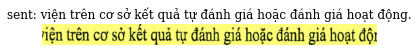

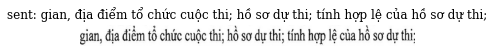

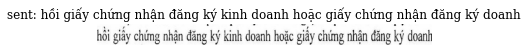

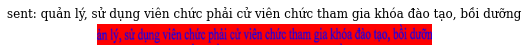

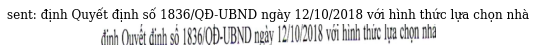

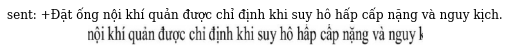

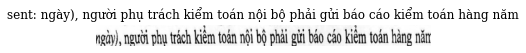

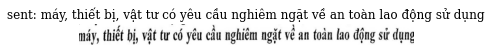

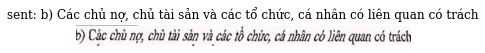

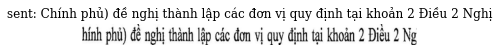

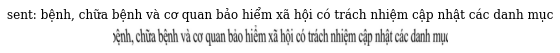

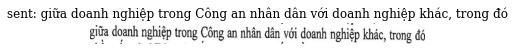

In [ ]:
trainer.visualize_dataset()

Train now

In [ ]:
import time
tic = time.time()
trainer.train()
print('\nTotal training time: %.2fs'%(time.time()-tic))

iter: 000200 - train loss: 0.762 - lr: 4.92e-05 - load time: 2.28 - gpu time: 156.21
iter: 000400 - train loss: 0.711 - lr: 7.66e-05 - load time: 0.05 - gpu time: 162.76
iter: 000600 - train loss: 0.708 - lr: 1.21e-04 - load time: 0.08 - gpu time: 160.15
iter: 000800 - train loss: 0.695 - lr: 1.81e-04 - load time: 0.05 - gpu time: 154.61
iter: 001000 - train loss: 0.698 - lr: 2.53e-04 - load time: 0.07 - gpu time: 164.96
iter: 001200 - train loss: 0.685 - lr: 3.36e-04 - load time: 0.05 - gpu time: 156.57
iter: 001400 - train loss: 0.672 - lr: 4.27e-04 - load time: 0.06 - gpu time: 154.62
iter: 001600 - train loss: 0.678 - lr: 5.20e-04 - load time: 0.05 - gpu time: 160.24
iter: 001800 - train loss: 0.691 - lr: 6.14e-04 - load time: 0.06 - gpu time: 153.72
iter: 002000 - train loss: 0.684 - lr: 7.04e-04 - load time: 0.08 - gpu time: 155.38
iter: 002000 - valid loss: 0.656 - acc full seq: 0.8359 - acc per char: 0.9655
iter: 002200 - train loss: 0.678 - lr: 7.87e-04 - load time: 0.08 - gpu

KeyboardInterrupt: ignored

In [ ]:
!cp -r weights/vgg_seq2seq.pth /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/weights/vgg_seq2seq_1m_wo_mlm.pth

Visualize prediction from our trained model


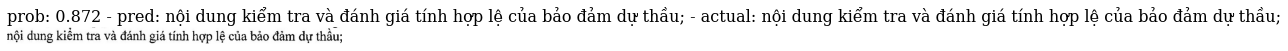

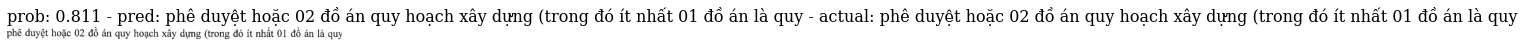

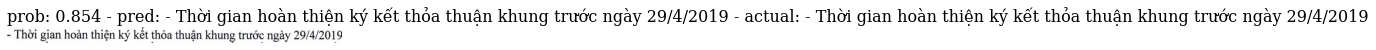

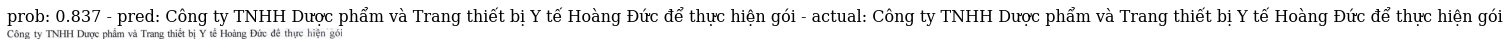

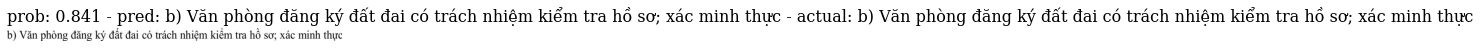

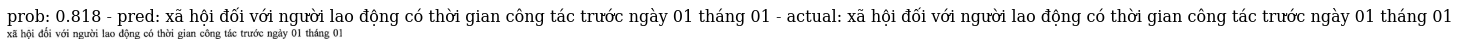

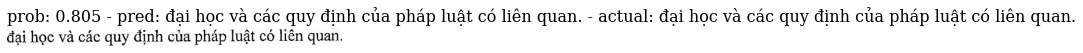

In [ ]:
trainer.visualize_prediction()

Compute full seq accuracy for full valid dataset

In [ ]:
trainer.precision()
print('Done')

(0.8901664046121593, 0.97543156)

In [ ]:
# !cp -r configs /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/configs
# !cp -r valid_hw /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/valid_hw
# !cp -r train_hw /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/train_hw

# Inference on real data

In [ ]:
# config = Cfg.load_config_from_name('vgg_seq2seq')
config = Cfg.load_config_from_name(model_name)

Change weights to your weights or using default weights from our pretrained model. Path can be url or local file

In [ ]:
config['weights'] = './weights/' + model_name + '.pth'
# config['weights'] = 'https://drive.google.com/uc?id=13327Y1tz1ohsm5YZMyXVMPIOjoOA0OaA'
config['cnn']['pretrained']=False
config['device'] = 'cuda:0'
config['predictor']['beamsearch']=False

In [ ]:
detector = Predictor(config)

In [ ]:
# load real data from drive
! cp /content/drive/MyDrive/Vin/VinBigdata/OmegaOCR/data/ocr/test_lines.zip test_lines.zip
! unzip -q test_lines.zip

In [ ]:
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

def get_file_path_by_type(path, extensions=('.jpg', '.png')):
    img_paths = []
    for x in os.listdir(path):
        for ext in extensions:
            if x.endswith(ext):
                img_paths.append(path + '/' + x)

    return img_paths

img_path = get_file_path_by_type("test_lines", extensions=('.jpg',))

predicts = []
times = []
for i in img_path:
  try:
    img = Image.open(open(i, 'rb'))
    tic = time.time()
    pred_sent, prob = detector.predict(img, return_prob=True)
    times.append(time.time() - tic)
    
    plt.figure()
    plt.imshow(img)
    plt.title('prob: {:.3f} - pred: {}'.format(prob, pred_sent), loc='left')
    plt.axis('off')
    plt.show()
    
  except:
    print(1)

# plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from pprint import pprint
import numpy as np

print("Average time prediction: %.2fs"%(np.mean(times)))

Average time prediction: 0.07s


# Evaluate the model

vgg_seq2seq:
- 6000 steps
- 182k lines, augmented
- training times: ~1.5h
- Tesla V100
- batch 64
- masked language model: 1 số token (char or word) trong training sequence bị dấu đi (dấu *)
- train set precision: 
- valid set precision: (0.877391247379455, 0.9728957)
- test set precision: 

- Average inference time: 0.071s

vgg_transformer:
- 6000 steps
- training set: 182k lines, augmented
- validation set: 30k lines, augmented
- test set: 30k lines
- training times: ~3h
- Tesla V100
- batch 64
- masked language model: 1 số token (char or word) trong training sequence bị giấu đi (dấu *)
- validation precision: (0.8705450733752621, 0.97061414)
- average inference time: 0.53s


In [ ]:
def read_lines(file_path):
  return open(file_path, 'r', encoding='utf8').read().strip().split('\n')

In [ ]:
def SER(hypo: str, ref:str):
    """
    Inputs:
      - hypo: predicted string from ocr
      - ref: correct string
    Returns (float) Sequence Error Rate between 2 strings
    """
    if hypo == ref:
      return 1
    else:
      return 0

def WER(hypo:str, ref:str):
    """
    Inputs:
        - hypo: predicted string from ocr
        - ref: correct string
    Returns (float) Word Error Rate between 2 strings
    """
    # Splits str to list of words 
    hypo = hypo.split()
    ref = ref.split()

    h = len(hypo)
    r = len(ref)
    D = np.zeros((r+1, h+1))
    D[0,:] = np.arange(h+1)
    D[:,0] = np.arange(r+1)
    for i in range(1,r+1):
        for j in range(1,h+1):
            if ref[i-1] == hypo[j-1]:
                D[i,j] = D[i-1,j-1]
            else:
                D[i,j] = min(D[i-1,j-1], D[i-1,j], D[i,j-1]) + 1
    return D[r,h]/r

def CER(hypo:str, ref:str):
    """
    Inputs:
        - hypo: predicted string from ocr
        - ref: correct string
    Returns (float) Character Error Rate between 2 strings
    """
    # No need to split strings to list of words.
    # hypo = hypo.split()
    # ref = ref.split()

    h = len(hypo)
    r = len(ref)
    D = np.zeros((r+1, h+1))
    D[0,:] = np.arange(h+1)
    D[:,0] = np.arange(r+1)
    for i in range(1,r+1):
        for j in range(1,h+1):
            if ref[i-1] == hypo[j-1]:
                D[i,j] = D[i-1,j-1]
            else:
                D[i,j] = min(D[i-1,j-1], D[i-1,j], D[i,j-1]) + 1
    return D[r,h]/r

In [ ]:
total_wer = 0.0
total_cer = 0.0
total_ser = 0.0
lines = read_lines('ocr_training/test_annotations.txt')
src = '/content/ocr_training/'
# from tqdm import tqdm
lines = lines[:30000] # Take the first 
for idx, line in enumerate(lines):
    file, content = line.split('\t')
    file = os.path.join(src, file)
    img = Image.open(file)
    s = detector.predict(img)
    total_wer += WER(s, content)
    total_cer += CER(s, content)
    total_ser += SER(s, content)

print('Average SER: ', total_ser/len(lines))    
print('Average WER: ', total_wer/len(lines))
print('Average CER: ', total_cer/len(lines))    

NameError: ignored